<a href="https://www.kaggle.com/code/fathyalin/titanic-starter-notebook?scriptVersionId=158948634" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
from sklearn.model_selection import GridSearchCV # for hyperparameter tuning

# Data Loading

In [2]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")

# we are going to concatenate train and test data to work on only one data
df = pd.concat([train, test])

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.tail() 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


 ****

**Null Values:** to see how many null values we have, we can use ***isnull()*** and ***sum()*** functions to sort them we use ***sort_values()***

In [5]:
df.isnull().sum().sort_values(ascending=False)

Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
PassengerId       0
Pclass            0
Name              0
Sex               0
SibSp             0
Parch             0
Ticket            0
dtype: int64

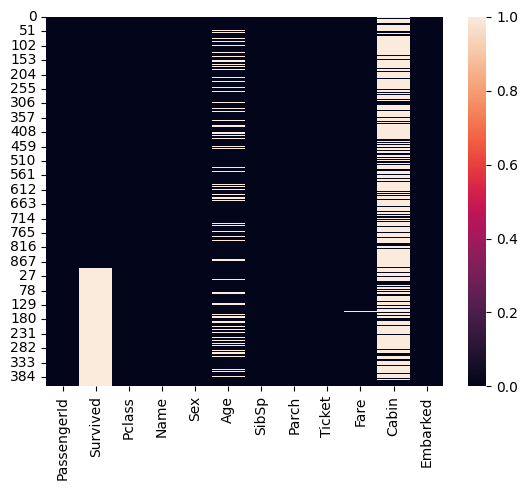

In [6]:
sns.heatmap(df.isnull())
plt.show()

# Missing Values and Feature Engineering

 ****

**Embarked:** There are only 2 missing values on Embarked column, so we are going to fill missing values with the most frequent one 

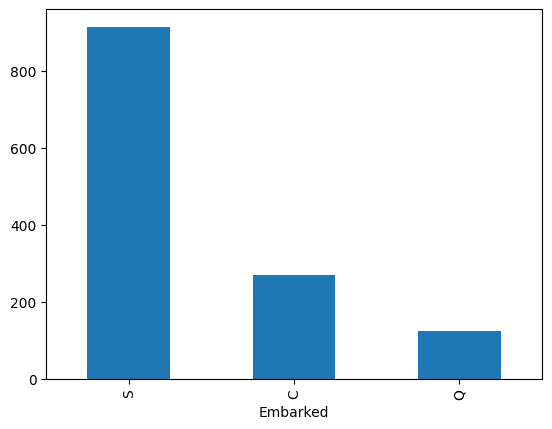

In [7]:
df["Embarked"].value_counts()\
        .plot(kind="bar")

plt.show()

In [8]:
df.Embarked = df.Embarked.fillna("S")

 ****

**Age and Fare:** In numerical columns we can just fill missing values with the **mean** of that column  

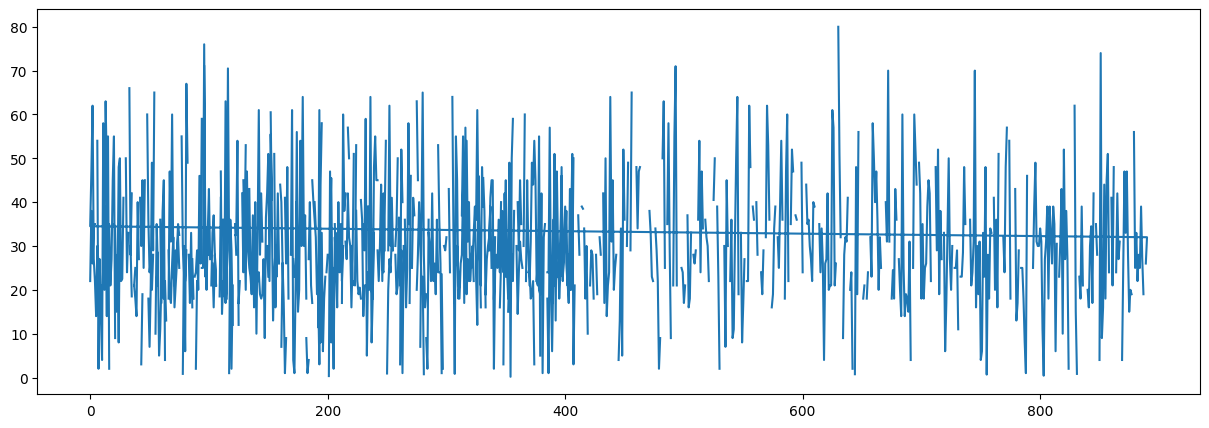

In [9]:
df["Age"].plot(kind="line", figsize=(15,5))
plt.show()

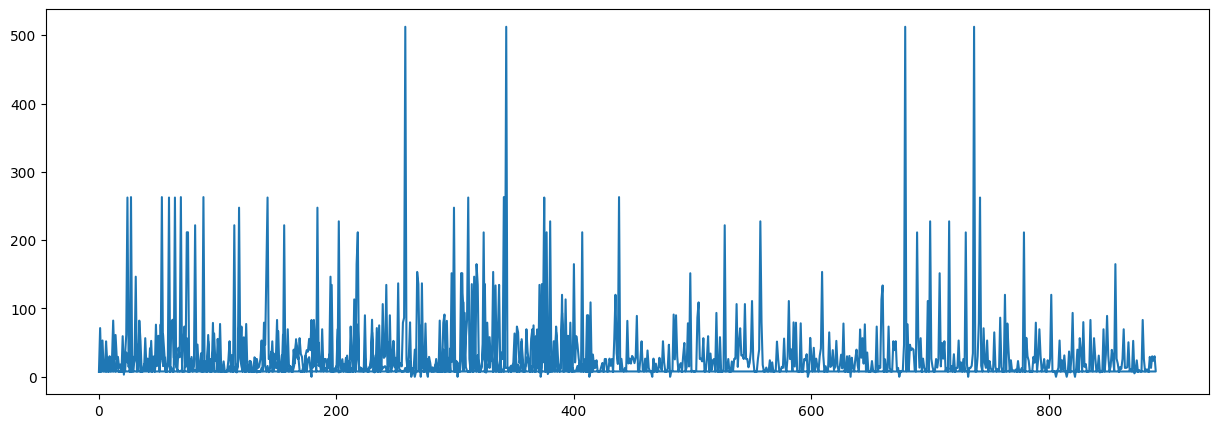

In [10]:
df["Fare"].plot(kind="line", figsize=(15,5))
plt.show()

In [11]:
df["Age"] = df["Age"].fillna(df.Age.mean())
df["Fare"] = df["Fare"].fillna(df.Fare.mean())

 ****

**Creating Title Column:** Name column itself is not important, but it has titles inside that we can use for model training.

In [12]:
df["Title"] = df["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'].value_counts()

Title
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: count, dtype: int64

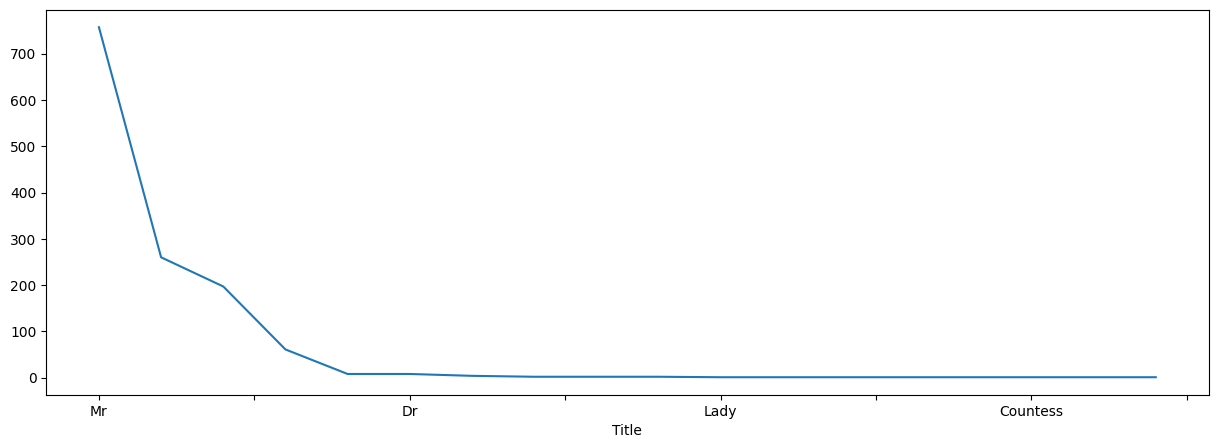

In [13]:
df["Title"].value_counts().plot(figsize=(15,5))
plt.show()

In [14]:
df["Title"].replace(["Ms", "Lady", "Countess", "Mlle", "Mme", "Dona",], "Miss", inplace=True)
df["Title"].replace(["Major", "Don", "Sir", "Capt", "Jonkheer"], "Mr", inplace=True)

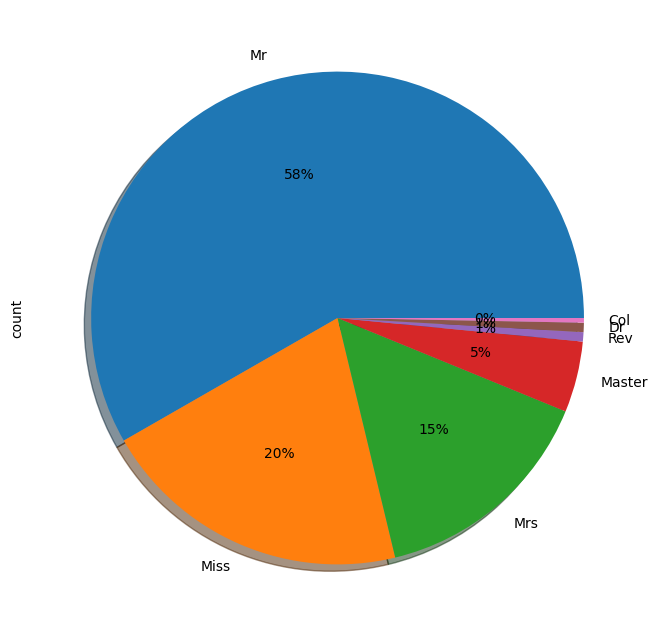

In [15]:
df["Title"].value_counts().plot(kind="pie", shadow=True, autopct='%1.0f%%', figsize=(8,8))
plt.show()

 ****

**PassengerId and Ticket** passender id and ticket is not important for our model, because id's and etc. has nothing to do with is someone dead or not

In [16]:
df.drop(["PassengerId", "Ticket"], axis=1, inplace=True)

 ****

**Family Size:** Data has 3 different columns that have information about number of people. We are going to just make them one separate them according to family sizes

In [17]:
df["FamilyMembers"] = df.SibSp + df.Parch + 1 

In [18]:
df["Single"] = df.FamilyMembers < 2
df["Small"] = (df.FamilyMembers > 1) & (df.FamilyMembers <5)
df["Medium"] = (df.FamilyMembers > 4) & (df.FamilyMembers <7)
df["Large"] = df.FamilyMembers > 6

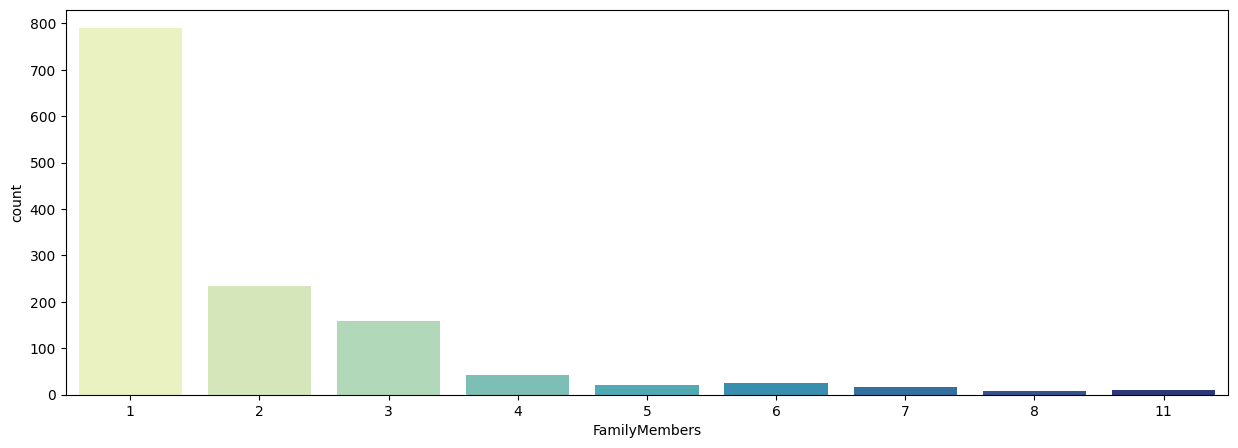

In [19]:
plt.figure(figsize=(15,5))
sns.countplot(data=df, x="FamilyMembers", palette="YlGnBu")
plt.show()

 ****

**Cabin:** Cabin column has a lot of missing values that we can not process on it. We are going to just drop it

In [20]:
df.drop("Cabin", axis=1, inplace=True)

In [21]:
df["Sex"].apply(str)

0        male
1      female
2      female
3      female
4        male
        ...  
413      male
414    female
415      male
416      male
417      male
Name: Sex, Length: 1309, dtype: object

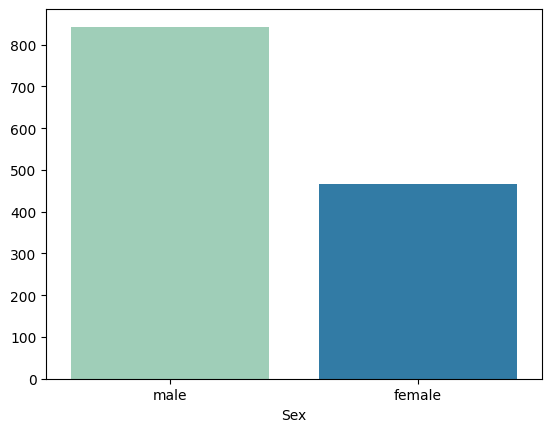

In [22]:
counts = df["Sex"].value_counts()
sns.barplot(x=counts.index, y=counts.values, palette="YlGnBu")
plt.show()

# Model Training

In [23]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilyMembers,Single,Small,Medium,Large
0,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Mr,2,False,True,False,False
1,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Mrs,2,False,True,False,False
2,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Miss,1,True,False,False,False
3,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Mrs,2,False,True,False,False
4,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Mr,1,True,False,False,False


**Dummy data:** Computers doesn't understand charachters, so we just turn them into numbers 

In [24]:
df = pd.get_dummies(df, drop_first=True) 
df

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilyMembers,Single,Small,Medium,...,"Name_van Melkebeke, Mr. Philemon",Sex_male,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev
0,0.0,3,22.000000,1,0,7.2500,2,False,True,False,...,False,True,False,True,False,False,False,True,False,False
1,1.0,1,38.000000,1,0,71.2833,2,False,True,False,...,False,False,False,False,False,False,False,False,True,False
2,1.0,3,26.000000,0,0,7.9250,1,True,False,False,...,False,False,False,True,False,False,True,False,False,False
3,1.0,1,35.000000,1,0,53.1000,2,False,True,False,...,False,False,False,True,False,False,False,False,True,False
4,0.0,3,35.000000,0,0,8.0500,1,True,False,False,...,False,True,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,NaN,3,29.881138,0,0,8.0500,1,True,False,False,...,False,True,False,True,False,False,False,True,False,False
414,NaN,1,39.000000,0,0,108.9000,1,True,False,False,...,False,False,False,False,False,False,True,False,False,False
415,NaN,3,38.500000,0,0,7.2500,1,True,False,False,...,False,True,False,True,False,False,False,True,False,False
416,NaN,3,29.881138,0,0,8.0500,1,True,False,False,...,False,True,False,True,False,False,False,True,False,False


There were 891 rows in train data. We just seperate them according to rows to train and test our data

In [25]:
train_new = df[:891]
test_new = df[891:]
del test_new['Survived']

In [26]:
X = train_new.drop("Survived", axis=1)
y = train_new["Survived"]

# Without Tuning XGBClassifier

In [27]:
model = xgb.XGBClassifier()

model.fit(X,y)
predictions1 = model.predict(test_new)

In [28]:
prediction = test[["PassengerId"]]
prediction.loc[:, ["Survived"]] = predictions1.astype(int)
prediction.to_csv("prediction1.csv", index=False)
# 74 accuracy

In [29]:
# uncomment these codes to run grid search for yourself
"""params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb_tuned = xgb.XGBClassifier()

grid_search = GridSearchCV(xgb_tuned, params, cv=5, scoring='accuracy')

grid_search.fit(X, y)

print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
"""

'params = {\n        \'min_child_weight\': [1, 5, 10],\n        \'gamma\': [0.5, 1, 1.5, 2, 5],\n        \'subsample\': [0.6, 0.8, 1.0],\n        \'colsample_bytree\': [0.6, 0.8, 1.0],\n        \'max_depth\': [3, 4, 5]\n        }\n\nxgb_tuned = xgb.XGBClassifier()\n\ngrid_search = GridSearchCV(xgb_tuned, params, cv=5, scoring=\'accuracy\')\n\ngrid_search.fit(X, y)\n\nprint("Best set of hyperparameters: ", grid_search.best_params_)\nprint("Best score: ", grid_search.best_score_)\n'

In [30]:
best_parameters = {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.8}
#best_parameters = grid_search.best_params_
tuned_model = xgb.XGBClassifier(**best_parameters)
tuned_model.fit(X,y)
predictions2 = tuned_model.predict(test_new)

In [31]:
prediction2 = test[["PassengerId"]]
prediction2.loc[:,["Survived"]] = predictions2.astype(int)
prediction2.to_csv("prediction2.csv", index=False)
# 77 accuracy